In [27]:
import os
import sys
import importlib

# Import initially
import base_config
from base_config import *

# When you need to reload after making changes:
importlib.reload(base_config)
from base_config import *

sys.path.append('./cnn_impl')
sys.path.append('./vit_impl')

# RELOAD CNN modules too:
import cnn_main
import cnn_config
import dataset
import cnn_model
import train
import test_flow
import utils
import vit_main
import vit_config
import model

importlib.reload(cnn_main)
importlib.reload(cnn_config)
importlib.reload(dataset)
importlib.reload(cnn_model)
importlib.reload(train)
importlib.reload(test_flow)
importlib.reload(utils)
importlib.reload(vit_main)
importlib.reload(vit_config)
importlib.reload(model)

from test_flow import test_model
from cnn_main import train_cnn
from cnn_config import CNNArchitecture
from cnn_config import RESULTS_DIR as cnn_results_dir
from cnn_config import CHECKPOINT_DIR as cnn_checkpoint_dir
import matplotlib.pyplot as plt

from vit_main import train_vit
from vit_config import RESULTS_DIR as vit_results_dir
from vit_config import CHECKPOINT_DIR as vit_checkpoint_dir

In [28]:
def compare_models(models_dict, save_path=None):
    """
    Compare training and validation metrics between any number of models
    
    Args:
        models_dict: Dictionary where keys are model names and values are dictionaries 
                    with keys 'train' and 'val' containing metrics for each model
                    Example: {
                        "Model 1": {"train": {...}, "val": {...}},
                        "Model 2": {"train": {...}, "val": {...}},
                        ...
                    }
        save_path: Optional path to save the plot
    """
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import numpy as np
    
    # Define colors and markers for different models
    colors = list(mcolors.TABLEAU_COLORS.values())
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x']
    
    # Extend colors and markers if we have more models than available styles
    num_models = len(models_dict)
    if num_models > len(colors):
        colors = colors * ((num_models // len(colors)) + 1)
    if num_models > len(markers):
        markers = markers * ((num_models // len(markers)) + 1)
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Create title based on number of models
    if num_models == 2:
        model_names = list(models_dict.keys())
        fig.suptitle(f'Model Comparison: {model_names[0]} vs {model_names[1]}', 
                    fontsize=16, fontweight='bold')
    else:
        fig.suptitle(f'Model Comparison: {num_models} Models', 
                    fontsize=16, fontweight='bold')
    
    # Plot for each model
    for idx, (model_name, metrics) in enumerate(models_dict.items()):
        train_metrics = metrics['train']
        val_metrics = metrics['val']
        
        epochs = range(1, len(train_metrics['loss']) + 1)
        color = colors[idx]
        marker = markers[idx]
        
        # Training Loss
        axes[0, 0].plot(epochs, train_metrics['loss'], color=color, linestyle='-', 
                       label=f'{model_name} Train', linewidth=2, marker=marker, markersize=3)
        
        # Validation Loss
        axes[0, 1].plot(epochs, val_metrics['loss'], color=color, linestyle='--',
                       label=f'{model_name} Val', linewidth=2, marker=marker, markersize=3)
        
        # Training Accuracy
        axes[0, 2].plot(epochs, train_metrics['accuracy'], color=color, linestyle='-',
                       label=f'{model_name} Train', linewidth=2, marker=marker, markersize=3)
        
        # Validation Accuracy
        axes[1, 0].plot(epochs, val_metrics['accuracy'], color=color, linestyle='--',
                       label=f'{model_name} Val', linewidth=2, marker=marker, markersize=3)
        
        # Validation F1 Score
        axes[1, 1].plot(epochs, val_metrics['f1_score'], color=color, linestyle='--',
                       label=f'{model_name} F1', linewidth=2, marker=marker, markersize=3)
        
        # Validation AUC
        axes[1, 2].plot(epochs, val_metrics['auc'], color=color, linestyle='--',
                       label=f'{model_name} AUC', linewidth=2, marker=marker, markersize=3)
    
    # Configure subplot titles and labels
    subplot_configs = [
        (axes[0, 0], 'Training Loss', 'Loss'),
        (axes[0, 1], 'Validation Loss', 'Loss'),
        (axes[0, 2], 'Training Accuracy', 'Accuracy'),
        (axes[1, 0], 'Validation Accuracy', 'Accuracy'),
        (axes[1, 1], 'Validation F1 Score', 'F1 Score'),
        (axes[1, 2], 'Validation AUC-ROC', 'AUC')
    ]
    
    for ax, title, ylabel in subplot_configs:
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylabel)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 Comparison plot saved to: {save_path}")
    
    plt.show()


In [29]:
def compare_test_results(test_results_dict, save_path=None):
    """
    Compare test metrics between multiple models using bar charts
    
    Args:
        test_results_dict: Dictionary where keys are model names and values are test result dictionaries
                          from test_cnn function
                          Example: {
                              "Model 1": test_results_1,
                              "Model 2": test_results_2,
                              ...
                          }
        save_path: Optional path to save the plot
    """
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import numpy as np
    
    # Extract model names and metrics
    model_names = list(test_results_dict.keys())
    
    # Metrics to compare (excluding non-numeric fields)
    metrics_to_plot = ['test_accuracy', 'test_precision', 'test_recall', 
                       'test_f1_score', 'test_auc', 'test_sensitivity', 'test_specificity']
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    # Define colors for different models
    colors = list(mcolors.TABLEAU_COLORS.values())
    if len(model_names) > len(colors):
        colors = colors * ((len(model_names) // len(colors)) + 1)
    
    # Create title based on number of models
    if len(model_names) == 2:
        fig.suptitle(f'Test Results Comparison: {model_names[0]} vs {model_names[1]}', 
                    fontsize=16, fontweight='bold')
    else:
        fig.suptitle(f'Test Results Comparison: {len(model_names)} Models', 
                    fontsize=16, fontweight='bold')
    
    # Plot each metric
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx]
        
        # Extract values for this metric
        values = []
        for model_name in model_names:
            values.append(test_results_dict[model_name][metric])
        
        # Create bar chart
        bars = ax.bar(model_names, values, color=colors[:len(model_names)], alpha=0.8)
        
        # Customize the plot
        metric_name = metric.replace('test_', '').replace('_', ' ').title()
        ax.set_title(f'Test {metric_name}', fontsize=12, fontweight='bold')
        ax.set_ylabel(metric_name)
        
        # Add value labels on top of bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=10)
        
        # Set y-axis limits for better visualization
        if metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score', 
                      'test_auc', 'test_sensitivity', 'test_specificity']:
            ax.set_ylim(0, 1.1)
        
        ax.grid(True, alpha=0.3, axis='y')
        
        # Rotate x-axis labels if needed
        if len(max(model_names, key=len)) > 10:
            ax.tick_params(axis='x', rotation=45)
    
    # Hide the last subplot if we have 7 metrics (odd number)
    axes[7].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 Test results comparison saved to: {save_path}")
    
    plt.show()
    
    # Print summary table
    print(f"\n📋 Test Results Summary:")
    print("=" * 100)
    print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'AUC':<10} {'Sensitivity':<12} {'Specificity':<12}")
    print("=" * 100)
    
    for model_name in model_names:
        results = test_results_dict[model_name]
        print(f"{model_name:<20} {results['test_accuracy']:<10.3f} {results['test_precision']:<10.3f} "
              f"{results['test_recall']:<10.3f} {results['test_f1_score']:<10.3f} {results['test_auc']:<10.3f} "
              f"{results['test_sensitivity']:<12.3f} {results['test_specificity']:<12.3f}")
    
    print("=" * 100)

# Compare different Data augemntation (Using CNN)

In [30]:
# Three data augmentations: None, Light, Agressive.

no_augmentation_trained_model, no_augmentation_metrics_train, no_augmentation_metrics_val, class_counts1,  no_augmentation_test_data_loader = train_cnn(
    architecture=CNNArchitecture.THREE_CONV_LAYERS,
    augmentation_strategy='none'
)

print(f"\n✅ no_augmentation training completed!")
print(f"   • Best validation F1: {max(no_augmentation_metrics_val['f1_score']):.4f}")

light_augmentation_trained_model, light_augmentation_metrics_train, light_augmentation_metrics_val, class_counts1, light_augmentation_test_data_loader = train_cnn(
    architecture=CNNArchitecture.THREE_CONV_LAYERS,
    augmentation_strategy='light'
)

print(f"\n✅ light_augmentation training completed!")
print(f"   • Best validation F1: {max(light_augmentation_metrics_val['f1_score']):.4f}")

aggressive_augmentation_trained_model, aggressive_augmentation_metrics_train, aggressive_augmentation_metrics_val, class_counts1,  aggressive_augmentation_test_data_loader = train_cnn(
    architecture=CNNArchitecture.THREE_CONV_LAYERS,
    augmentation_strategy='aggressive'
)

print(f"\n✅ agressive_augmentation training completed!")
print(f"   • Best validation F1: {max(aggressive_augmentation_metrics_val['f1_score']):.4f}")

🏥 Starting CNN Pneumonia Detection Training...
🔧 Setting up training environment...
   Device: cuda

📁 Loading dataset...
🔄 Creating data loaders with 'none' augmentation...
📊 Calculating dataset statistics...
   Dataset statistics: mean=0.4823, std=0.2216
✅ Created train dataset with 4185 images
   - NORMAL: 1079
   - PNEUMONIA: 3106
   - Augmentation: none
✅ Created val dataset with 1047 images
   - NORMAL: 270
   - PNEUMONIA: 777
   - Augmentation: none
✅ Created test dataset with 624 images
   - NORMAL: 234
   - PNEUMONIA: 390
   - Augmentation: none
   Training set: 1079 NORMAL, 3106 PNEUMONIA
   Class ratio: 0.3:1

🏗️ Creating model...
🚀 Creating CNN model with 3 layers architecture...
   Total trainable parameters: 286,433
📋 Model Architecture Summary:
Architecture: 3 layers
Total trainable parameters: 286,433
Input size: (1, 1, 224, 224)

Layer Details:
------------------------------------------------------------
block1.0                       Conv2d(1, 16, kernel_size=(5, 5), 

📊 Comparison plot saved to: models_comparison.png


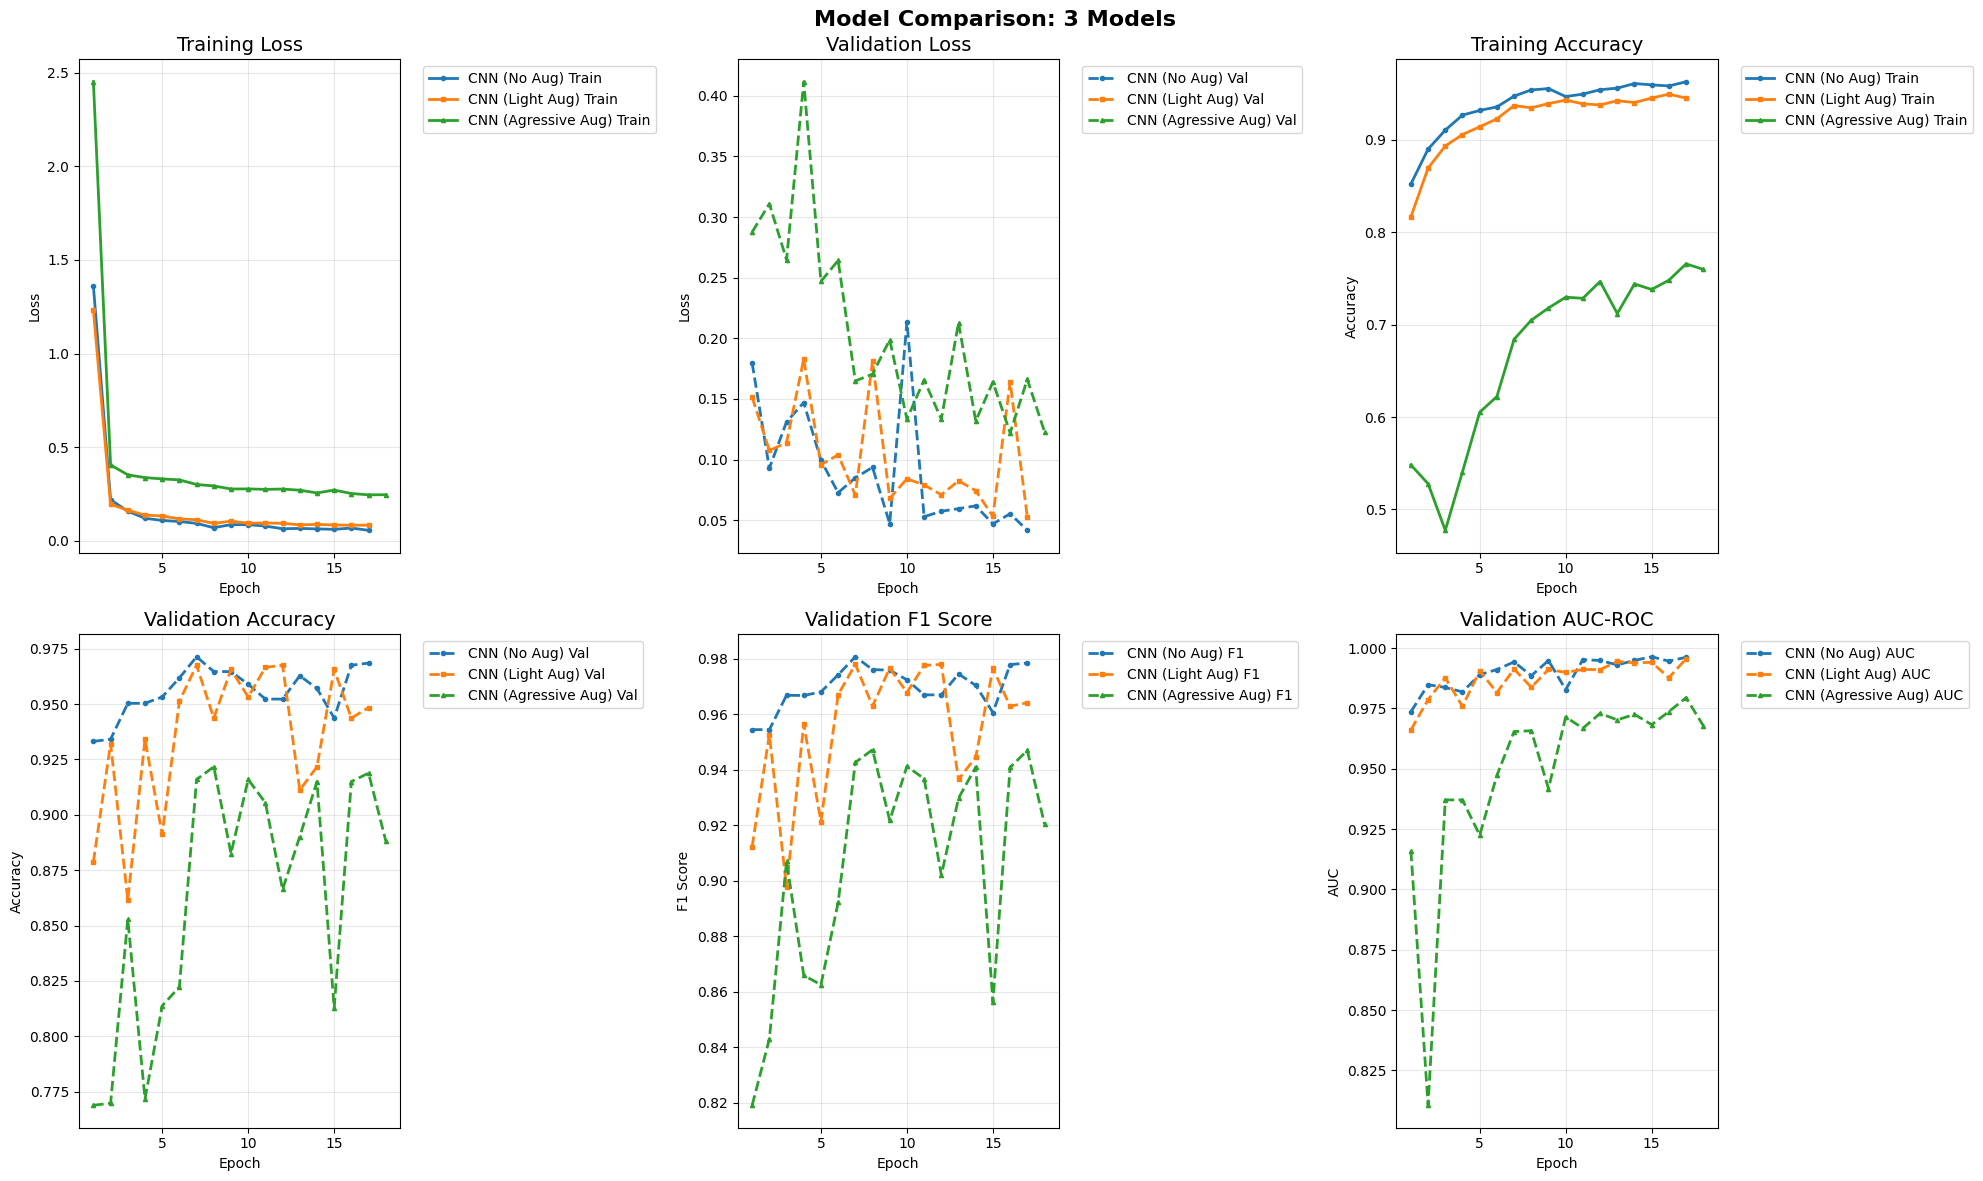

In [31]:
models_comparison = {
    "CNN (No Aug)": {
        'train': no_augmentation_metrics_train,
        'val': no_augmentation_metrics_val
    },
    "CNN (Light Aug)": {
        'train': light_augmentation_metrics_train,
        'val': light_augmentation_metrics_val
    },
    "CNN (Agressive Aug)": {
        'train': aggressive_augmentation_metrics_train,
        'val': aggressive_augmentation_metrics_val
    },
}

# Create comparison plot for all models
compare_models(
    models_comparison, 
    save_path="models_comparison.png"
)

🧪 Starting CNN Model Testing...
🔧 Setting up training environment...
   Device: cuda

🧪 Evaluating model on test set...
📊 Test Results:
   • Accuracy: 0.7372
   • Precision: 0.7062
   • Recall/Sensitivity: 0.9923
   • Specificity: 0.3120
   • F1-Score: 0.8252
   • AUC-ROC: 0.9428

🎯 Final Test Performance:
   • Test Accuracy: 0.7372
   • Test F1-Score: 0.8252
   • Test AUC-ROC: 0.9428
   • Test Sensitivity: 0.9923
   • Test Specificity: 0.3120
📝 Test results saved to: cnn_impl/models/test_results.json
🧪 Starting CNN Model Testing...
🔧 Setting up training environment...
   Device: cuda

🧪 Evaluating model on test set...
📊 Test Results:
   • Accuracy: 0.7933
   • Precision: 0.7554
   • Recall/Sensitivity: 0.9897
   • Specificity: 0.4658
   • F1-Score: 0.8568
   • AUC-ROC: 0.9393

🎯 Final Test Performance:
   • Test Accuracy: 0.7933
   • Test F1-Score: 0.8568
   • Test AUC-ROC: 0.9393
   • Test Sensitivity: 0.9897
   • Test Specificity: 0.4658
📝 Test results saved to: cnn_impl/models/test

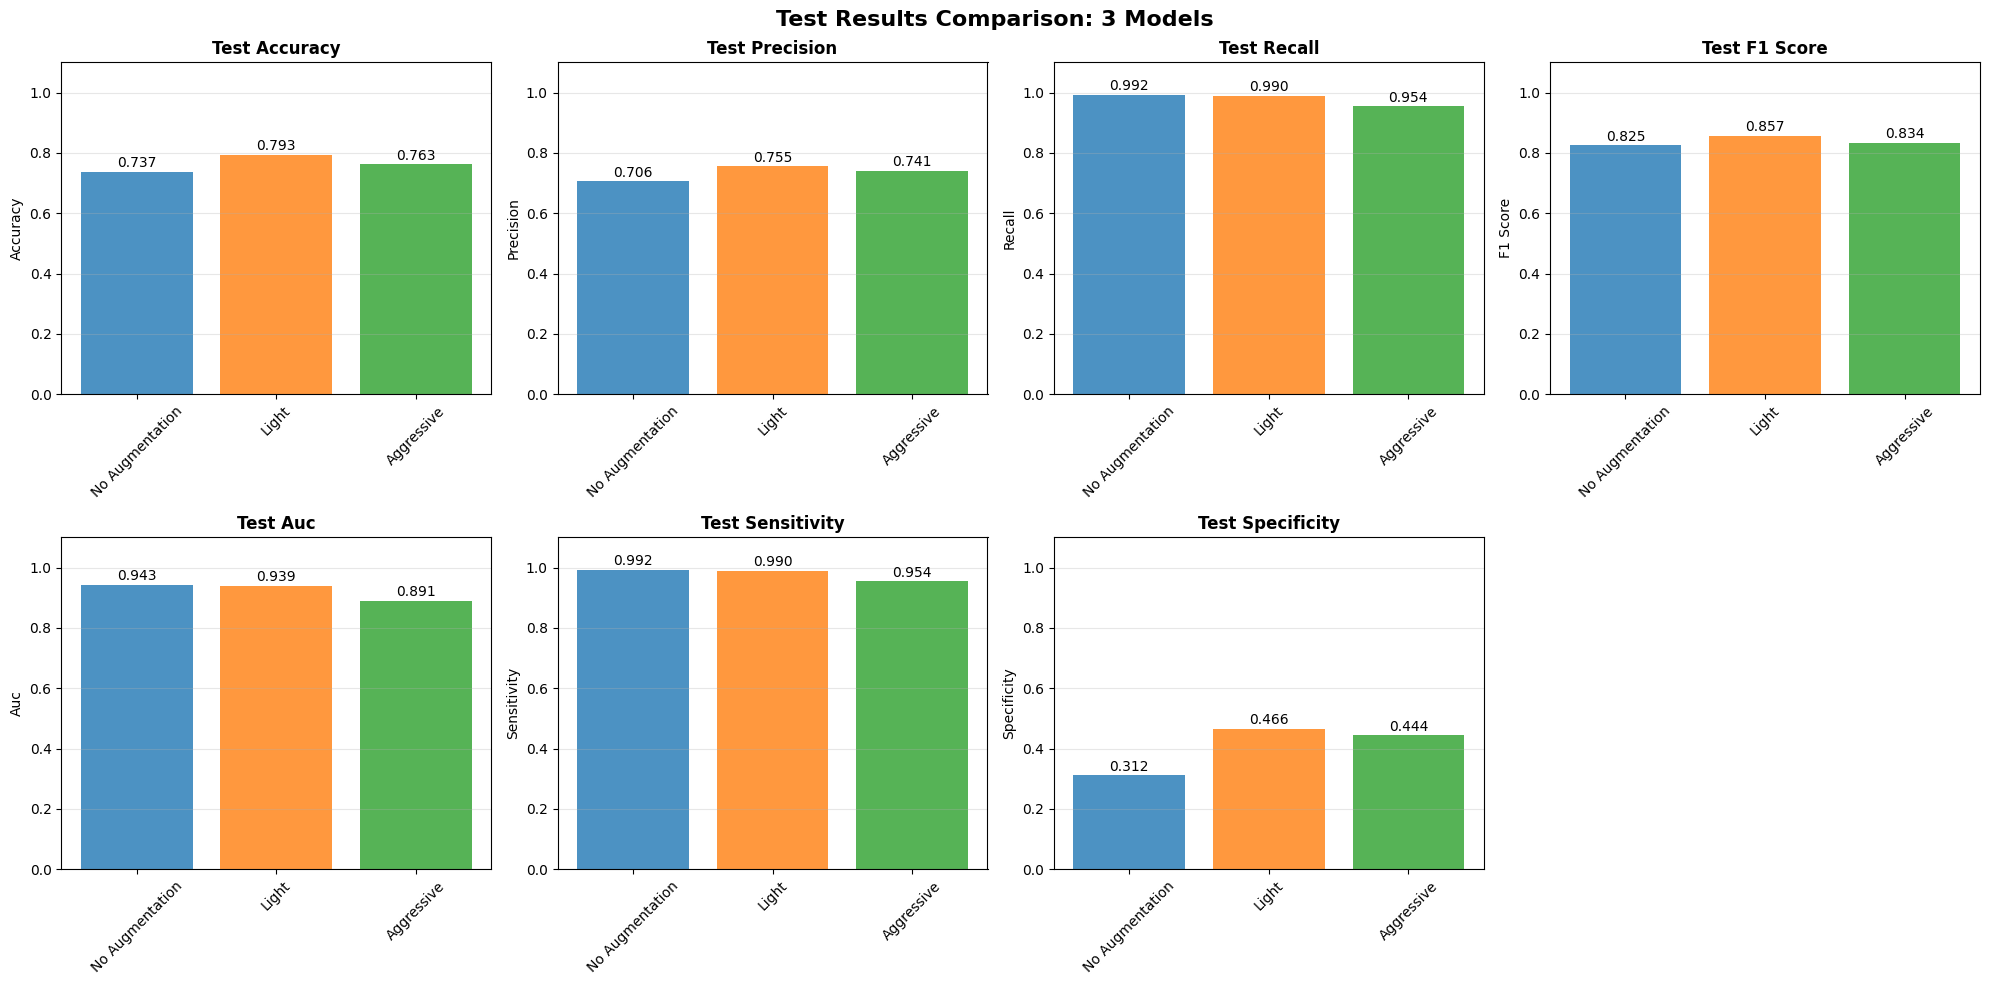


📋 Test Results Summary:
Model                Accuracy   Precision  Recall     F1-Score   AUC        Sensitivity  Specificity 
No Augmentation      0.737      0.706      0.992      0.825      0.943      0.992        0.312       
Light                0.793      0.755      0.990      0.857      0.939      0.990        0.466       
Aggressive           0.763      0.741      0.954      0.834      0.891      0.954        0.444       


In [32]:
no_augmentation_test_results = test_model(no_augmentation_trained_model,
                                          no_augmentation_test_data_loader,
                                          cnn_results_dir, cnn_checkpoint_dir)

light_augmentation_test_results = test_model(
    light_augmentation_trained_model, light_augmentation_test_data_loader,
    cnn_results_dir, cnn_checkpoint_dir)

aggressive_augmentation_test_results = test_model(
    aggressive_augmentation_trained_model,
    aggressive_augmentation_test_data_loader, cnn_results_dir,
    cnn_checkpoint_dir)

test_comparison = {
    "No Augmentation": no_augmentation_test_results,
    "Light": light_augmentation_test_results,
    "Aggressive": aggressive_augmentation_test_results,
}

# Create comparison plot for all models
compare_test_results(test_comparison, save_path="models_comparison.png")

# Compare CNN models architecture - 2,3,4 Convo layers

In [33]:
# Three data atchitectures: 2, 3 and 4 convo layers

two_trained_model, two_metrics_train, two_metrics_val, class_counts1, two_test_data_loader = train_cnn(
    architecture=CNNArchitecture.TWO_CONV_LAYERS,
    augmentation_strategy='light'
)

print(f"\n✅ two training completed!")
print(f"   • Best validation F1: {max(two_metrics_val['f1_score']):.4f}")

three_trained_model, three_metrics_train, three_metrics_val, class_counts1, three_test_data_loader = train_cnn(
    architecture=CNNArchitecture.THREE_CONV_LAYERS,
    augmentation_strategy='light'
)

print(f"\n✅ three training completed!")
print(f"   • Best validation F1: {max(three_metrics_val['f1_score']):.4f}")

four_trained_model, four_metrics_train, four_metrics_val, class_counts1, four_test_data_loader = train_cnn(
    architecture=CNNArchitecture.FOUR_CONV_LAYERS,
    augmentation_strategy='light'
)

print(f"\n✅ agressive_augmentation training completed!")
print(f"   • Best validation F1: {max(four_metrics_val['f1_score']):.4f}")

🏥 Starting CNN Pneumonia Detection Training...
🔧 Setting up training environment...
   Device: cuda

📁 Loading dataset...
🔄 Creating data loaders with 'light' augmentation...
📊 Calculating dataset statistics...
   Dataset statistics: mean=0.4823, std=0.2216
✅ Created train dataset with 4185 images
   - NORMAL: 1079
   - PNEUMONIA: 3106
   - Augmentation: light
✅ Created val dataset with 1047 images
   - NORMAL: 270
   - PNEUMONIA: 777
   - Augmentation: none
✅ Created test dataset with 624 images
   - NORMAL: 234
   - PNEUMONIA: 390
   - Augmentation: none
   Training set: 1079 NORMAL, 3106 PNEUMONIA
   Class ratio: 0.3:1

🏗️ Creating model...
🚀 Creating CNN model with 2 layers architecture...
   Total trainable parameters: 136,737
📋 Model Architecture Summary:
Architecture: 2 layers
Total trainable parameters: 136,737
Input size: (1, 1, 224, 224)

Layer Details:
------------------------------------------------------------
block1.0                       Conv2d(1, 16, kernel_size=(5, 5)

📊 Comparison plot saved to: models_comparison.png


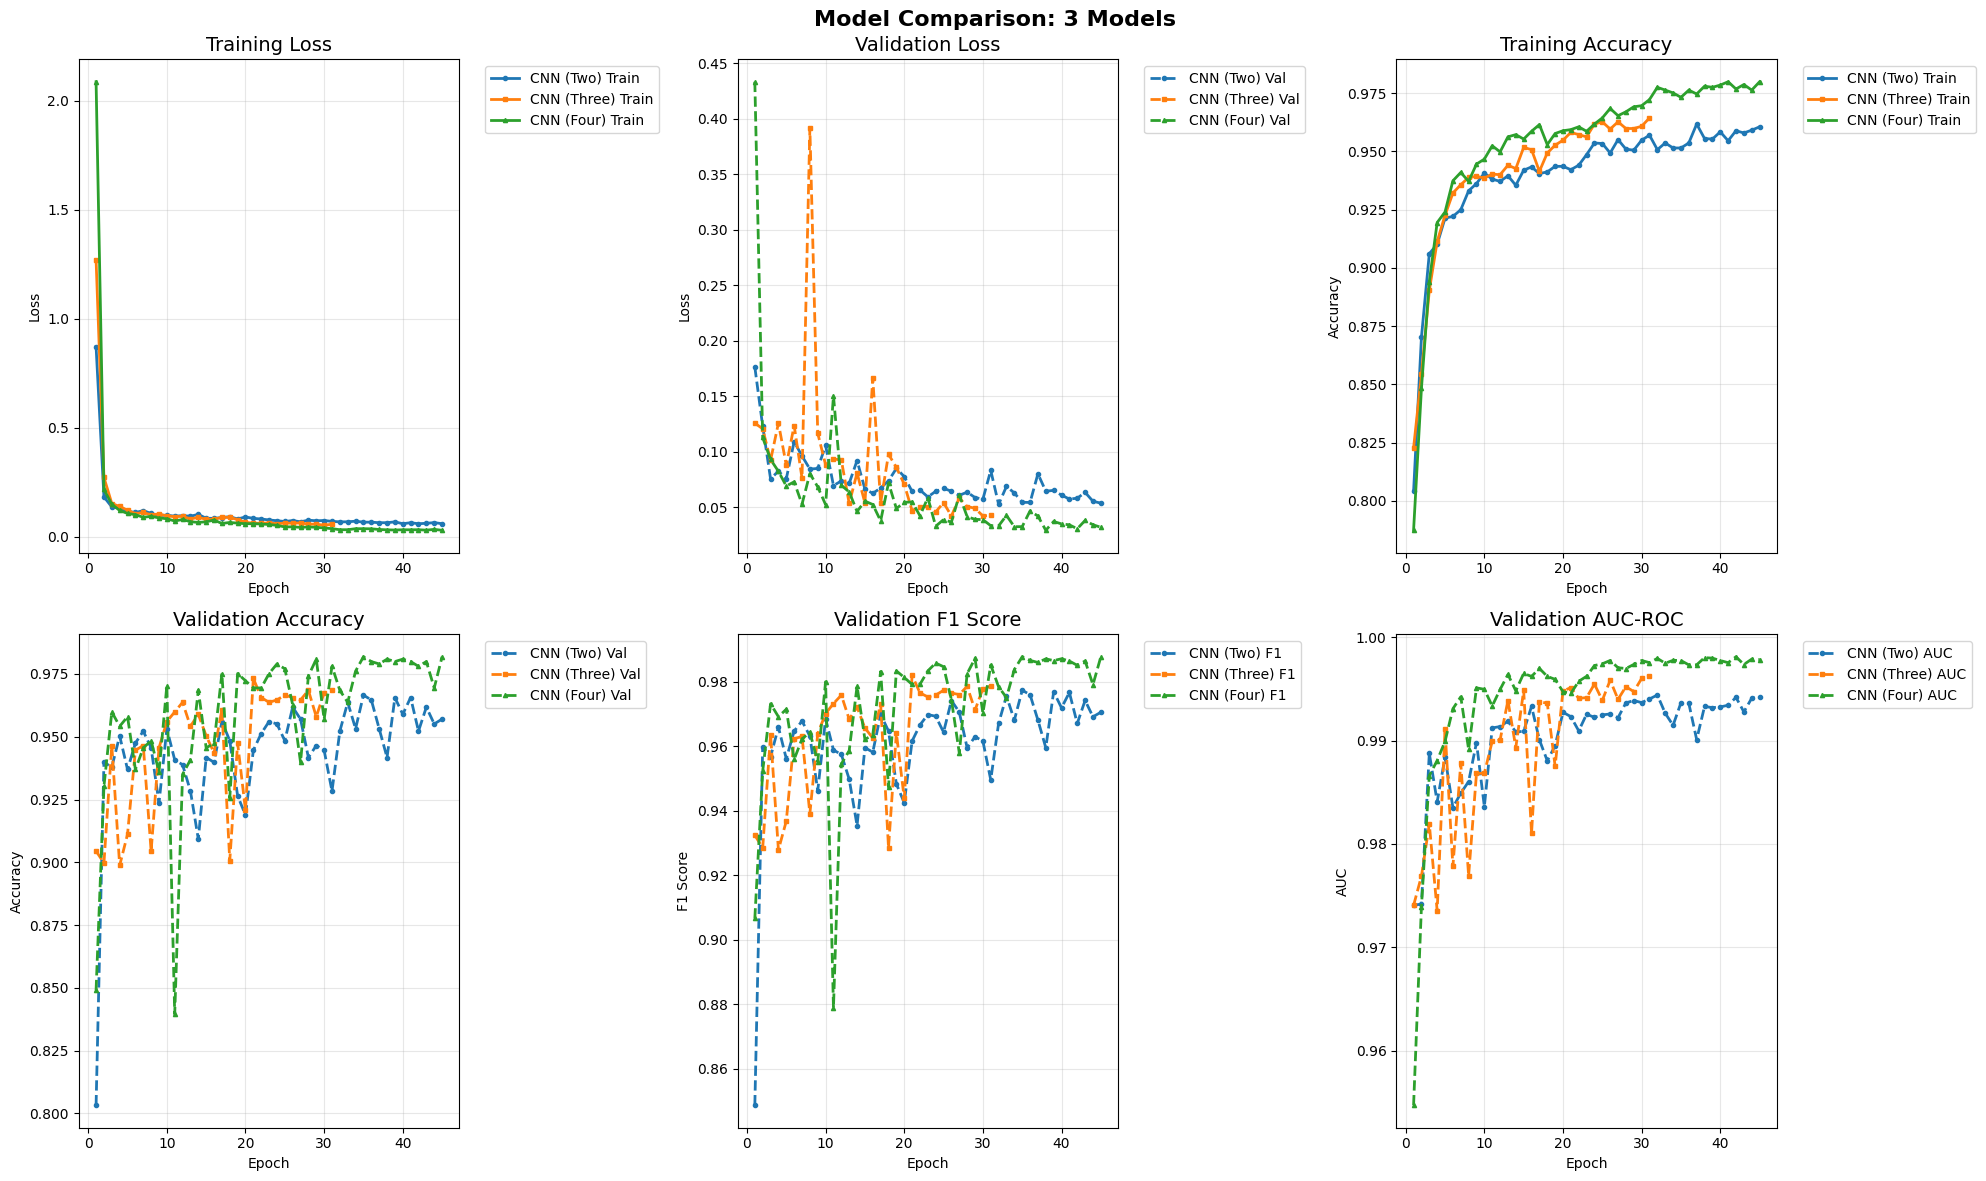

In [34]:
models_comparison = {
    "CNN (Two)": {
        'train': two_metrics_train,
        'val': two_metrics_val
    },
    "CNN (Three)": {
        'train': three_metrics_train,
        'val': three_metrics_val
    },
    "CNN (Four)": {
        'train': four_metrics_train,
        'val': four_metrics_val
    },
}

# Create comparison plot for all models
compare_models(
    models_comparison, 
    save_path="models_comparison.png"
)

🧪 Starting CNN Model Testing...
🔧 Setting up training environment...
   Device: cuda

🧪 Evaluating model on test set...
📊 Test Results:
   • Accuracy: 0.7869
   • Precision: 0.7525
   • Recall/Sensitivity: 0.9821
   • Specificity: 0.4615
   • F1-Score: 0.8521
   • AUC-ROC: 0.9334

🎯 Final Test Performance:
   • Test Accuracy: 0.7869
   • Test F1-Score: 0.8521
   • Test AUC-ROC: 0.9334
   • Test Sensitivity: 0.9821
   • Test Specificity: 0.4615
📝 Test results saved to: cnn_impl/models/test_results.json
🧪 Starting CNN Model Testing...
🔧 Setting up training environment...
   Device: cuda

🧪 Evaluating model on test set...
📊 Test Results:
   • Accuracy: 0.7788
   • Precision: 0.7414
   • Recall/Sensitivity: 0.9923
   • Specificity: 0.4231
   • F1-Score: 0.8487
   • AUC-ROC: 0.9346

🎯 Final Test Performance:
   • Test Accuracy: 0.7788
   • Test F1-Score: 0.8487
   • Test AUC-ROC: 0.9346
   • Test Sensitivity: 0.9923
   • Test Specificity: 0.4231
📝 Test results saved to: cnn_impl/models/test

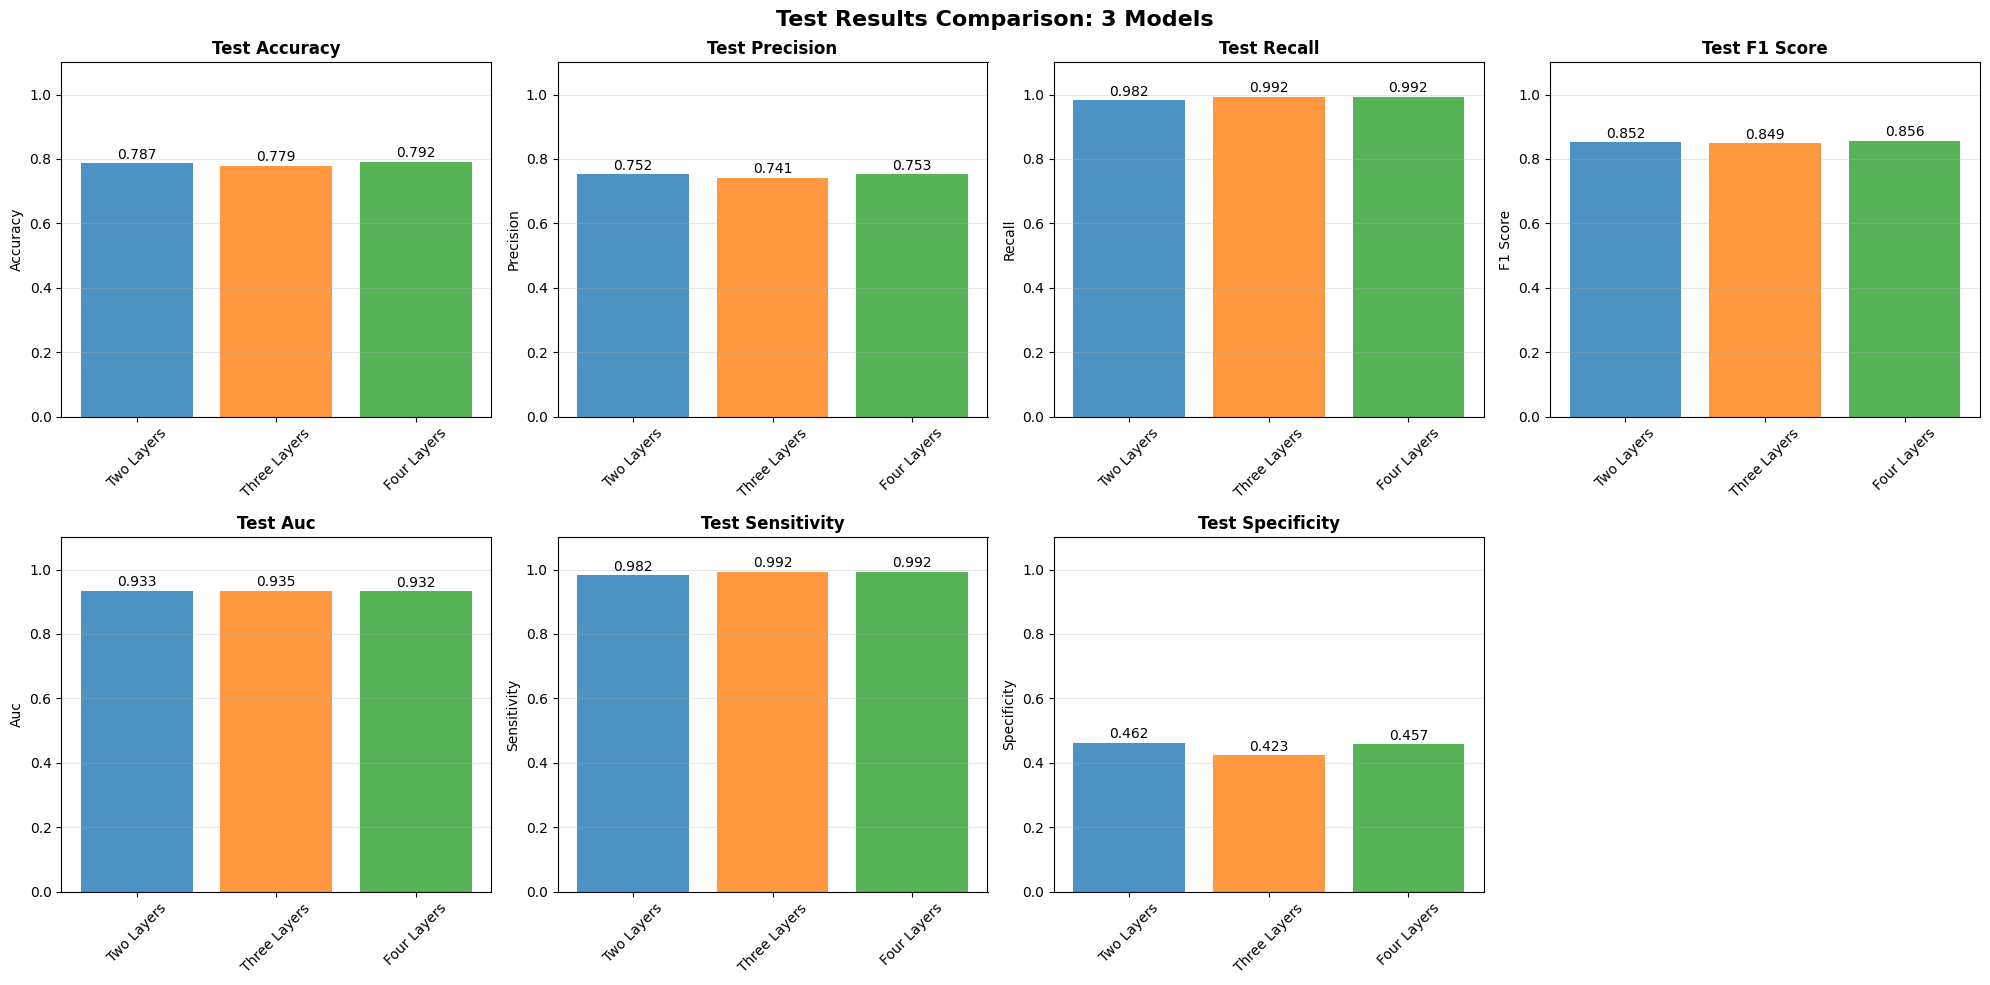


📋 Test Results Summary:
Model                Accuracy   Precision  Recall     F1-Score   AUC        Sensitivity  Specificity 
Two Layers           0.787      0.752      0.982      0.852      0.933      0.982        0.462       
Three Layers         0.779      0.741      0.992      0.849      0.935      0.992        0.423       
Four Layers          0.792      0.753      0.992      0.856      0.932      0.992        0.457       


In [35]:
two_test_results = test_model(two_trained_model, two_test_data_loader,
                              cnn_results_dir, cnn_checkpoint_dir)
three_test_results = test_model(three_trained_model, three_test_data_loader,
                                cnn_results_dir, cnn_checkpoint_dir)
four_test_results = test_model(four_trained_model, four_test_data_loader,
                               cnn_results_dir, cnn_checkpoint_dir)

test_comparison = {
    "Two Layers": two_test_results,
    "Three Layers":three_test_results,
    "Four Layers":four_test_results,
}

# Create comparison plot for all models
compare_test_results(
    test_comparison, 
    save_path="models_comparison.png"
)

# VIT

In [11]:

%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('/home/assaf-taubenfeld/Projects/deep-learning-idc/assignments/final_project')

from vit_impl.vit_main import train_vit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
one_trained_model, one_metrics_train, one_metrics_val, class_counts1,  one_test_data_loader = train_vit(
    unfreeze_epochs=1,
    augmentation_strategy='light'
)

five_trained_model, five_metrics_train, five_metrics_val, class_counts1,  five_test_data_loader = train_vit(
    unfreeze_epochs=5,
    augmentation_strategy='light'
)


2
🏥 Starting ViT Pneumonia Detection Training...
🔧 Setting up training environment...
   Device: cuda

📊 Loading and preparing data...
🔄 Creating data loaders with 'light' augmentation...
📊 Calculating dataset statistics...
   Dataset statistics: mean=0.4823, std=0.2216
✅ Created train dataset with 4185 images
   - NORMAL: 1079
   - PNEUMONIA: 3106
   - Augmentation: light
✅ Created val dataset with 1047 images
   - NORMAL: 270
   - PNEUMONIA: 777
   - Augmentation: none
✅ Created test dataset with 624 images
   - NORMAL: 234
   - PNEUMONIA: 390
   - Augmentation: none
   Training set: 1079 NORMAL, 3106 PNEUMONIA
   Class ratio: 0.3:1

🤖 Creating model...
50
🏭 Creating ViT model for pneumonia detection...
🚀 Loading pre-trained ViT model: google/vit-base-patch16-224


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
- vit.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 1, 16, 16]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Successfully loaded google/vit-base-patch16-224
✅ Classifier head updated: 768 -> 1
🔧 Adapting model for grayscale input...
   Original input channels: 1
   Target input channels: 1 (grayscale)
✅ Successfully adapted patch embeddings for grayscale input
   New patch embedding shape: torch.Size([768, 1, 16, 16])
🧊 Freezing backbone layers...
✅ Backbone frozen:
   Frozen parameters: 85,405,440
   Trainable parameters: 769
✅ ViT model successfully adapted for pneumonia detection!

📊 Model Information:
   Model: google/vit-base-patch16-224
   Input: 1-channel grayscale images (224x224)
   Output: 1 classes (NORMAL, PNEUMONIA)
   Total parameters: 85,406,209
   Trainable parameters: 769
   Frozen parameters: 85,405,440
   Patch size: 16x16
   Backbone status: FROZEN

🔧 Expected Shapes:
   Input: (batch_size, 1, 224, 224)
   Output: (batch_size, 1)
📋 Freeze-then-Unfreeze Strategy:
   Phase 1 (Frozen): Epochs 0-48 (49 epochs)
   Phase 2 (Unfrozen): Epochs 49-49 (1 epochs)
   Unfreeze transi

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
- vit.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 1, 16, 16]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Successfully loaded google/vit-base-patch16-224
✅ Classifier head updated: 768 -> 1
🔧 Adapting model for grayscale input...
   Original input channels: 1
   Target input channels: 1 (grayscale)
✅ Successfully adapted patch embeddings for grayscale input
   New patch embedding shape: torch.Size([768, 1, 16, 16])
🧊 Freezing backbone layers...
✅ Backbone frozen:
   Frozen parameters: 85,405,440
   Trainable parameters: 769
✅ ViT model successfully adapted for pneumonia detection!

📊 Model Information:
   Model: google/vit-base-patch16-224
   Input: 1-channel grayscale images (224x224)
   Output: 1 classes (NORMAL, PNEUMONIA)
   Total parameters: 85,406,209
   Trainable parameters: 769
   Frozen parameters: 85,405,440
   Patch size: 16x16
   Backbone status: FROZEN

🔧 Expected Shapes:
   Input: (batch_size, 1, 224, 224)
   Output: (batch_size, 1)
📋 Freeze-then-Unfreeze Strategy:
   Phase 1 (Frozen): Epochs 0-44 (45 epochs)
   Phase 2 (Unfrozen): Epochs 45-49 (5 epochs)
   Unfreeze transi

In [24]:

twenty_trained_model, twenty_metrics_train, twenty_metrics_val, class_counts1,  twenty_test_data_loader = train_vit(
    unfreeze_epochs=20,
    augmentation_strategy='light'
)

2
🏥 Starting ViT Pneumonia Detection Training...
🔧 Setting up training environment...
   Device: cuda

📊 Loading and preparing data...
🔄 Creating data loaders with 'light' augmentation...
📊 Calculating dataset statistics...
   Dataset statistics: mean=0.4823, std=0.2216
✅ Created train dataset with 4185 images
   - NORMAL: 1079
   - PNEUMONIA: 3106
   - Augmentation: light
✅ Created val dataset with 1047 images
   - NORMAL: 270
   - PNEUMONIA: 777
   - Augmentation: none
✅ Created test dataset with 624 images
   - NORMAL: 234
   - PNEUMONIA: 390
   - Augmentation: none
   Training set: 1079 NORMAL, 3106 PNEUMONIA
   Class ratio: 0.3:1

🤖 Creating model...
50
🏭 Creating ViT model for pneumonia detection...
🚀 Loading pre-trained ViT model: google/vit-base-patch16-224


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
- vit.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 1, 16, 16]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Successfully loaded google/vit-base-patch16-224
✅ Classifier head updated: 768 -> 1
🔧 Adapting model for grayscale input...
   Original input channels: 1
   Target input channels: 1 (grayscale)
✅ Successfully adapted patch embeddings for grayscale input
   New patch embedding shape: torch.Size([768, 1, 16, 16])
🧊 Freezing backbone layers...
✅ Backbone frozen:
   Frozen parameters: 85,405,440
   Trainable parameters: 769
✅ ViT model successfully adapted for pneumonia detection!

📊 Model Information:
   Model: google/vit-base-patch16-224
   Input: 1-channel grayscale images (224x224)
   Output: 1 classes (NORMAL, PNEUMONIA)
   Total parameters: 85,406,209
   Trainable parameters: 769
   Frozen parameters: 85,405,440
   Patch size: 16x16
   Backbone status: FROZEN

🔧 Expected Shapes:
   Input: (batch_size, 1, 224, 224)
   Output: (batch_size, 1)
📋 Freeze-then-Unfreeze Strategy:
   Phase 1 (Frozen): Epochs 0-29 (30 epochs)
   Phase 2 (Unfrozen): Epochs 30-49 (20 epochs)
   Unfreeze trans

📊 Comparison plot saved to: models_comparison.png


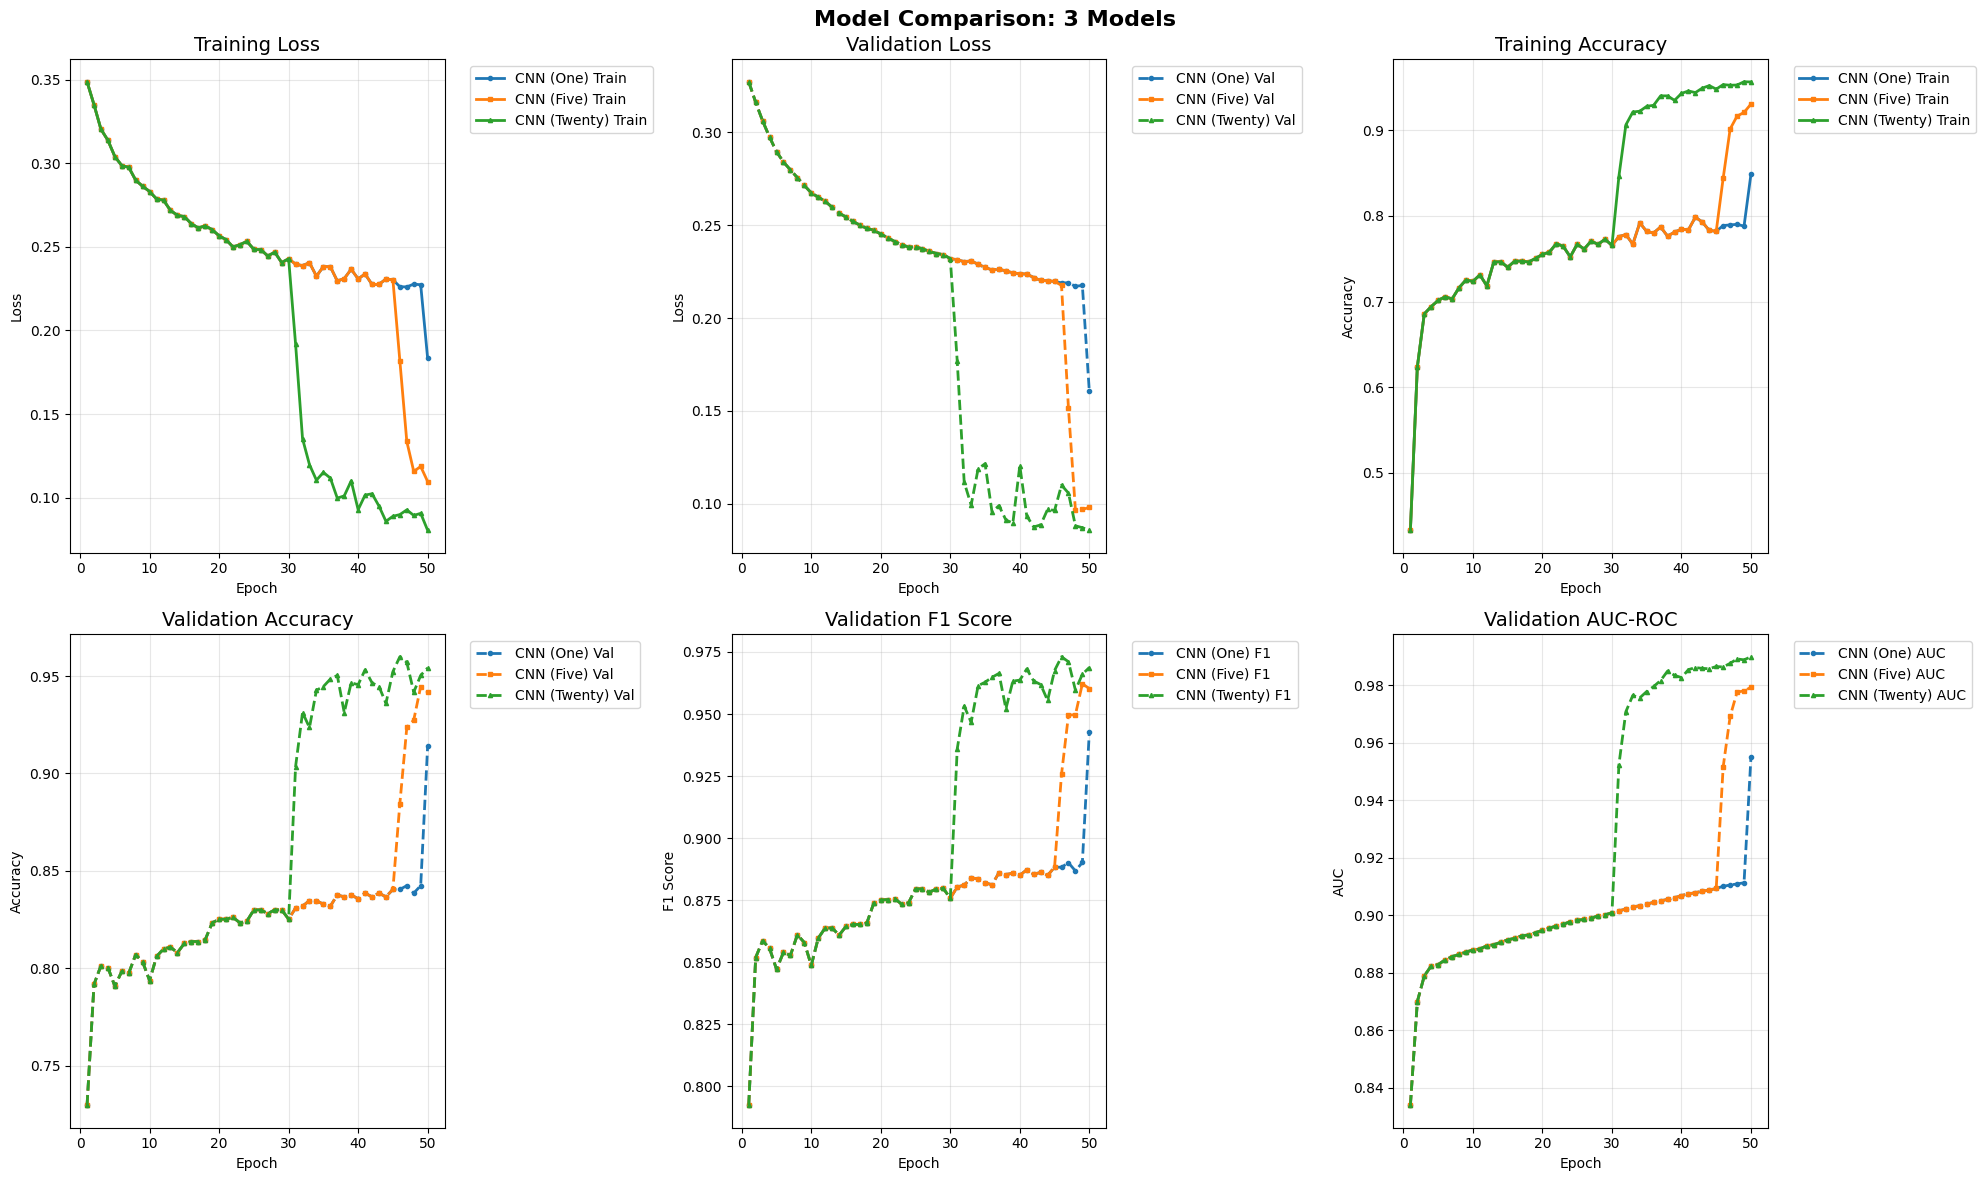

In [25]:
vit_models_comparison = {
    "CNN (One)": {
        'train': one_metrics_train,
        'val': one_metrics_val
    },
    "CNN (Five)": {
        'train': five_metrics_train,
        'val': five_metrics_val
    },
    "CNN (Twenty)": {
        'train': twenty_metrics_train,
        'val': twenty_metrics_val
    },
}

# Create comparison plot for all models
compare_models(
    vit_models_comparison, 
    save_path="models_comparison.png"
)

🧪 Starting CNN Model Testing...
🔧 Setting up training environment...
   Device: cuda

🧪 Evaluating model on test set...
📊 Test Results:
   • Accuracy: 0.7628
   • Precision: 0.7430
   • Recall/Sensitivity: 0.9487
   • Specificity: 0.4530
   • F1-Score: 0.8333
   • AUC-ROC: 0.8684

🎯 Final Test Performance:
   • Test Accuracy: 0.7628
   • Test F1-Score: 0.8333
   • Test AUC-ROC: 0.8684
   • Test Sensitivity: 0.9487
   • Test Specificity: 0.4530
📝 Test results saved to: vit_impl/models/test_results.json
🧪 Starting CNN Model Testing...
🔧 Setting up training environment...
   Device: cuda

🧪 Evaluating model on test set...
📊 Test Results:
   • Accuracy: 0.8285
   • Precision: 0.8137
   • Recall/Sensitivity: 0.9410
   • Specificity: 0.6410
   • F1-Score: 0.8728
   • AUC-ROC: 0.9124

🎯 Final Test Performance:
   • Test Accuracy: 0.8285
   • Test F1-Score: 0.8728
   • Test AUC-ROC: 0.9124
   • Test Sensitivity: 0.9410
   • Test Specificity: 0.6410
📝 Test results saved to: vit_impl/models/test

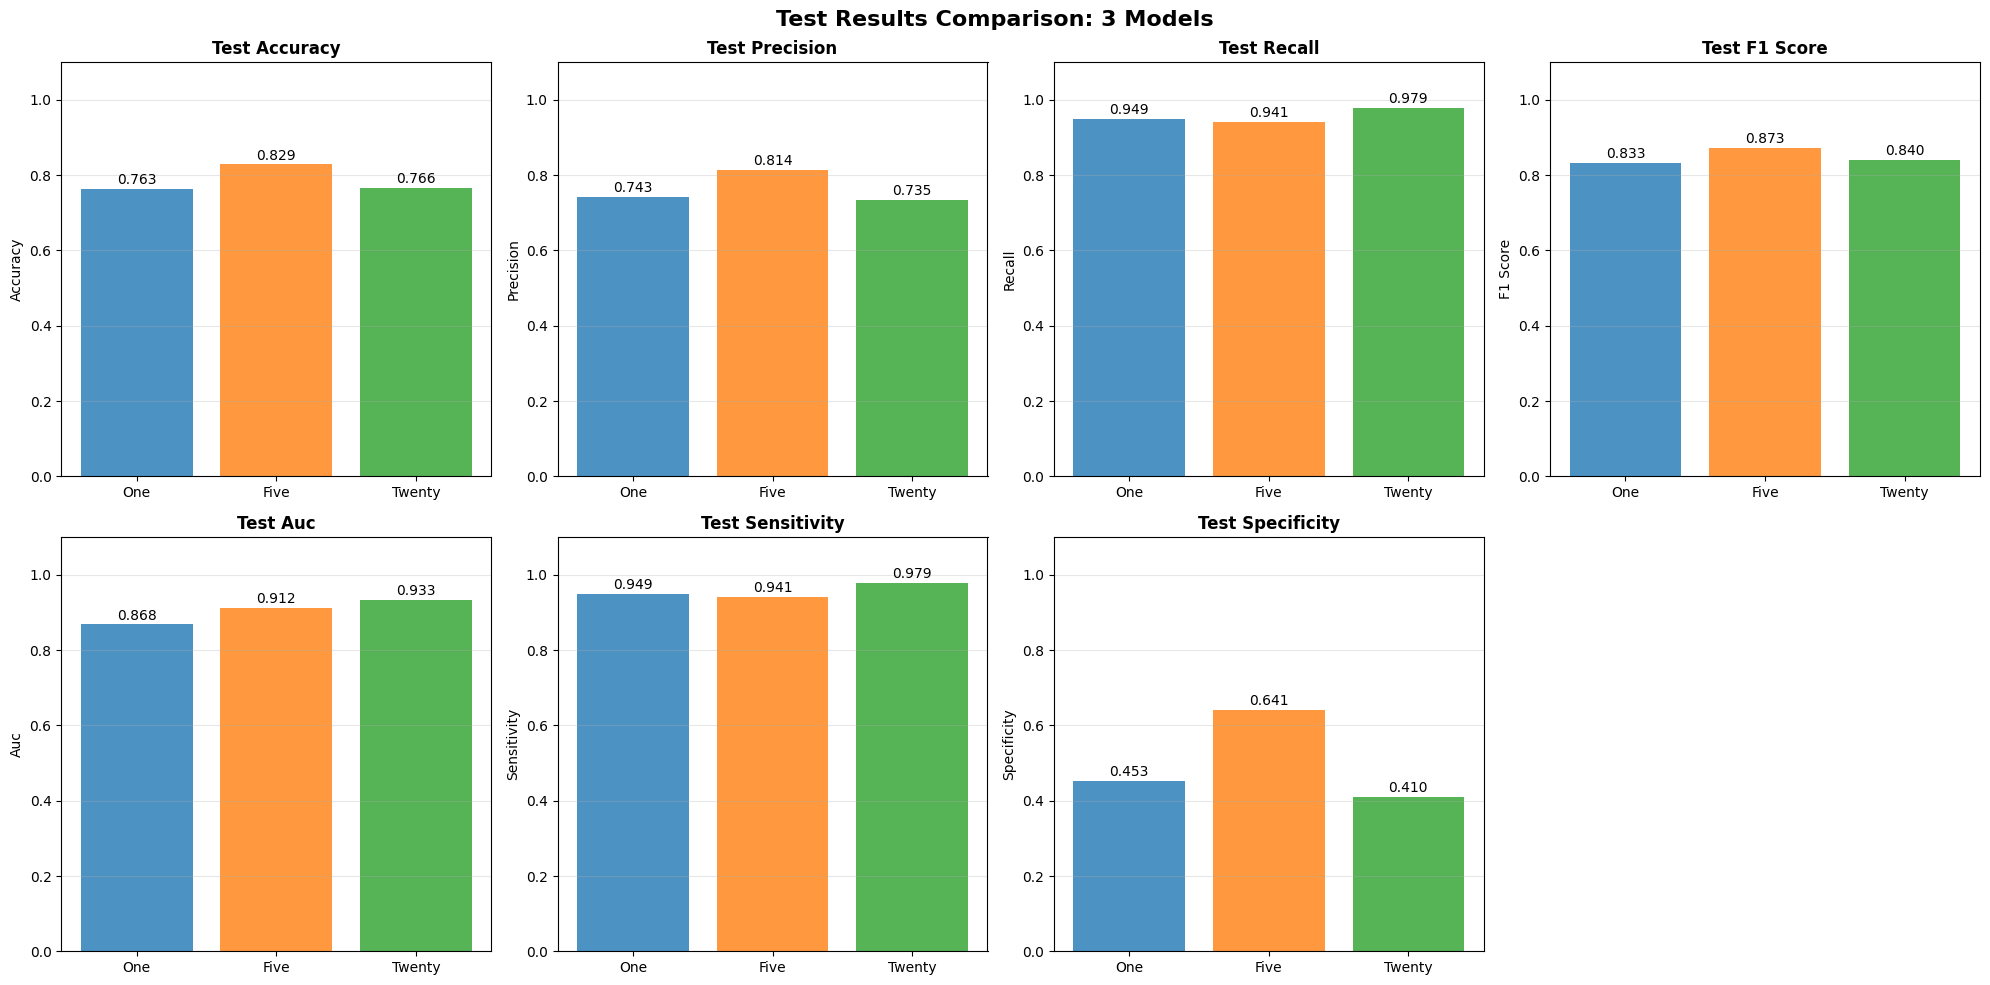


📋 Test Results Summary:
Model                Accuracy   Precision  Recall     F1-Score   AUC        Sensitivity  Specificity 
One                  0.763      0.743      0.949      0.833      0.868      0.949        0.453       
Five                 0.829      0.814      0.941      0.873      0.912      0.941        0.641       
Twenty               0.766      0.735      0.979      0.840      0.933      0.979        0.410       


In [26]:
one_test_results = test_model(one_trained_model, one_test_data_loader,
                              vit_results_dir, vit_checkpoint_dir)
five_test_results = test_model(five_trained_model, five_test_data_loader,
                                vit_results_dir, vit_checkpoint_dir)
twenty_test_results = test_model(twenty_trained_model, twenty_test_data_loader,
                               vit_results_dir, vit_checkpoint_dir)

vit_test_comparison = {
    "One": one_test_results,
    "Five":five_test_results,
    "Twenty":twenty_test_results,
}

# Create comparison plot for all models
compare_test_results(
    vit_test_comparison, 
    save_path="models_comparison.png"
)

# Compare CNN and ViT on the same graph

📊 Test results comparison saved to: models_comparison.png


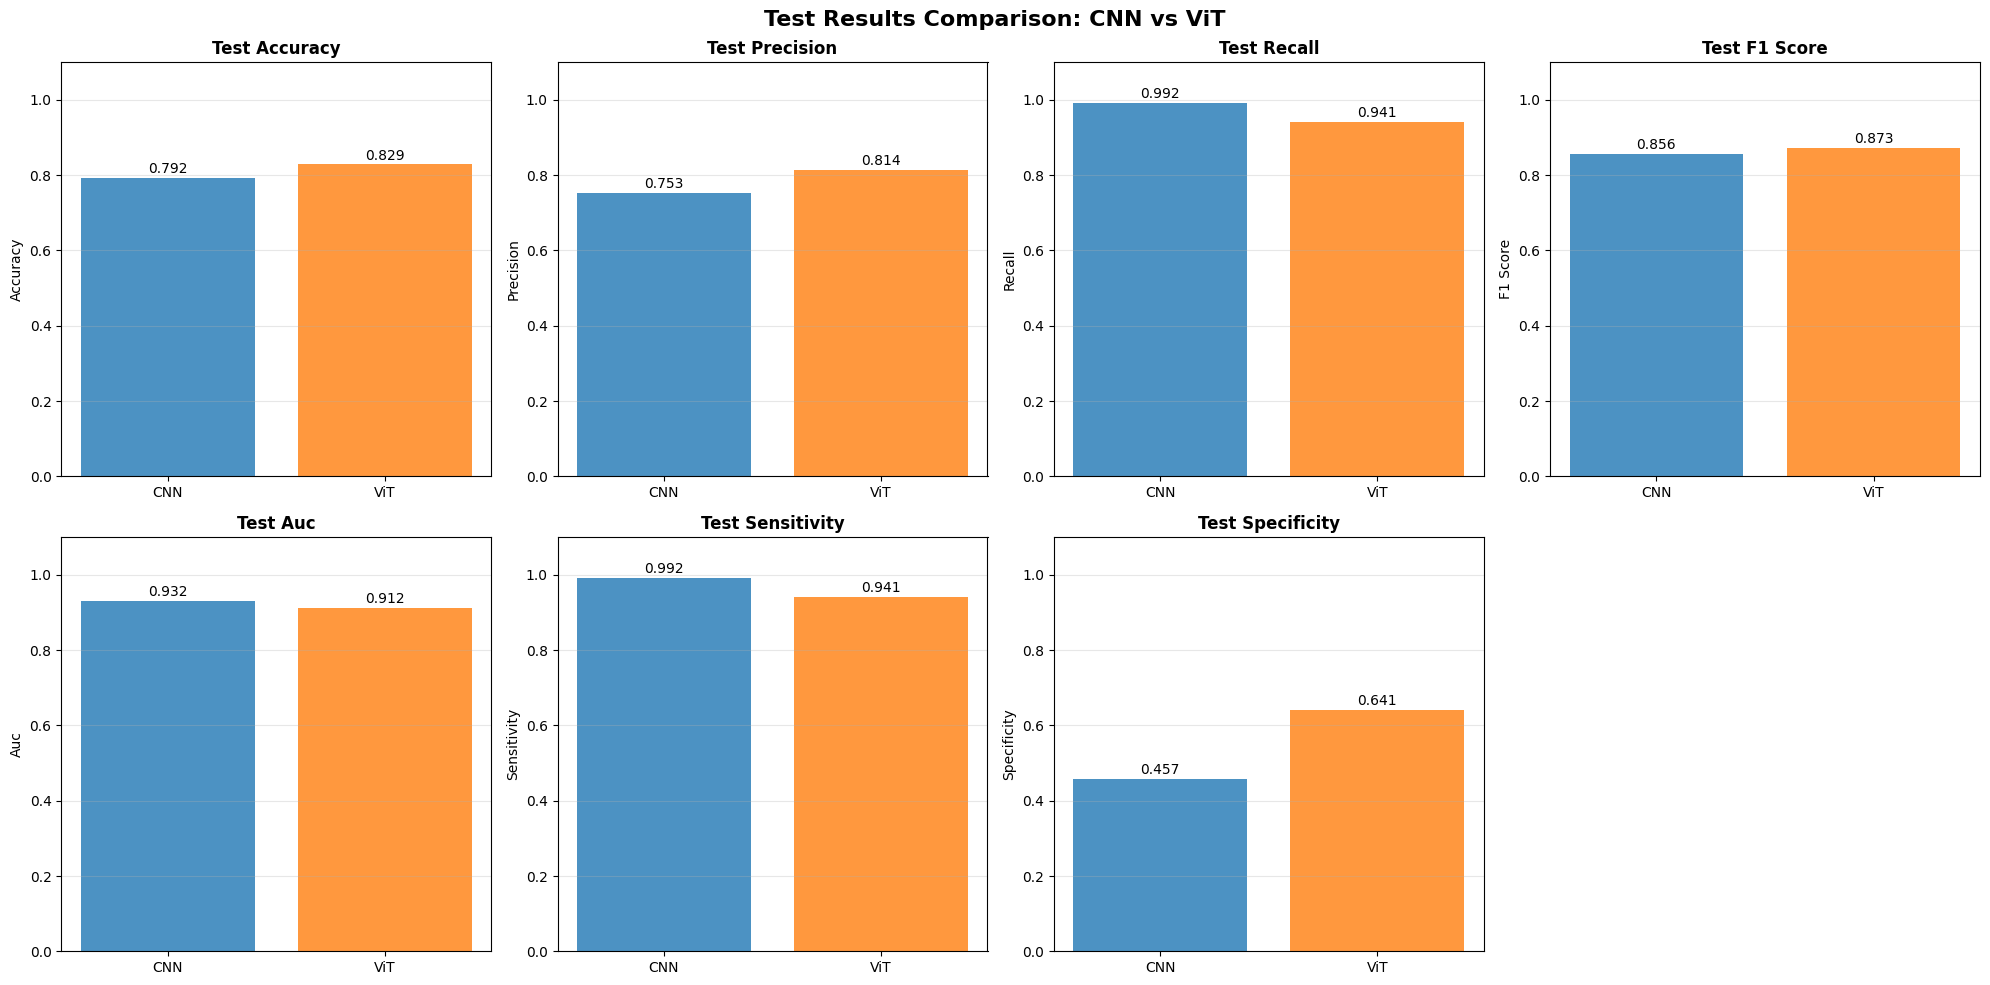


📋 Test Results Summary:
Model                Accuracy   Precision  Recall     F1-Score   AUC        Sensitivity  Specificity 
CNN                  0.792      0.753      0.992      0.856      0.932      0.992        0.457       
ViT                  0.829      0.814      0.941      0.873      0.912      0.941        0.641       


In [36]:

cnn_vit_test_comparison = {
    "CNN": four_test_results,
    "ViT":five_test_results,
}

# Create comparison plot for all models
compare_test_results(
    cnn_vit_test_comparison, 
    save_path="models_comparison.png"
)